# Meteorology Uncertainty Quantification
# Regression Analysis for Air Temperature, Humidity, and Soil Moisture

This notebook performs comprehensive regression analysis on three meteorological targets:
- **Air Temperature Error** (Ta_C_error)
- **Humidity Error** (RH_error)  
- **Soil Moisture Error** (SM_error)

For each target, we analyze the relationship with independent variables and build OLS regression models with proper statistical inference.

## 1. Import Required Libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from JET3 import load_ECOv002_calval_JET_outputs, INPUT_VARIABLES

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

## 2. Load and Prepare Data

In [18]:
# Load ECOv002 calibration/validation data
df = load_ECOv002_calval_JET_outputs()

# Prepare in-situ reference data
df["insitu_RH"] = df["RH_percentage"]
df["insitu_SM"] = df["SM_surf"]

# Add LST error column
df["ST_C_error"] = df["LST_err"]

# Calculate error metrics for all three targets
df["Ta_C_error"] = df["Ta_C"] - df["insitu_Ta_C"]
df["Ta_C_error_abs"] = np.abs(df["Ta_C_error"])

df["RH_error"] = df["RH"] - df["insitu_RH"]
df["RH_error_abs"] = np.abs(df["RH_error"])

df["SM_error"] = df["SM"] - df["insitu_SM"]
df["SM_error_abs"] = np.abs(df["SM_error"])

print(f"Dataset shape: {df.shape}")
print(f"\nAvailable columns: {len(df.columns)}")
df.head()

Dataset shape: (1065, 189)

Available columns: 189


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_73216/4278723910.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["insitu_SM"] = df["SM_surf"]
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_73216/4278723910.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["ST_C_error"] = df["LST_err"]
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_73216/4278723910.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,WUE,AuxiliaryNWP,insitu_SM,ST_C_error,Ta_C_error,Ta_C_error_abs,RH_error,RH_error_abs,SM_error,SM_error_abs
0,0,US-NC3,ENF,Cfa,270.34520,78.53355,392.85184,307.02197,487.383423,118.91628,...,1.943556,NaN,0.201566,2.56,0.857850,0.857850,-0.076633,0.076633,-0.009207,0.009207
1,1,US-Mi3,CVM,Dfb,232.14160,229.20093,640.11847,375.08930,106.825577,167.91946,...,2.421845,NaN,0.420438,1.16,-2.004618,2.004618,NaN,NaN,-0.127222,0.127222
2,2,US-Mi3,CVM,Dfb,356.35574,335.23154,625.66170,284.68625,NaN,132.93634,...,5.670131,NaN,0.406938,2.12,-4.084138,4.084138,NaN,NaN,0.026498,0.026498
3,3,US-Mi3,CVM,Dfb,332.93840,326.68680,624.25433,251.41449,178.827545,141.13242,...,6.158837,NaN,0.398036,1.48,-1.106204,1.106204,NaN,NaN,-0.006793,0.006793
4,4,US-Mi3,CVM,Dfb,286.85403,237.21654,511.08218,228.52017,154.791626,114.80941,...,4.846558,NaN,0.397494,1.88,-1.053609,1.053609,NaN,NaN,-0.063624,0.063624


## 3. Define Independent Variables

In [19]:
# Define independent variables for regression analysis
INPUT_VARIABLES = [
    "NDVI",
    "ST_C",
    "ST_C_error",
    "SZA_deg",
    "albedo",
    "canopy_height_meters",
    "elevation_m",
    "emissivity",
    "wind_speed_mps",
]

# Verify all variables are in the dataset
vars_in_df = [v for v in INPUT_VARIABLES if v in df.columns]
missing_vars = [v for v in INPUT_VARIABLES if v not in df.columns]

print(f"Independent Variables Available: {len(vars_in_df)}")
print(f"  {', '.join(vars_in_df)}")
if missing_vars:
    print(f"\nMissing Variables: {len(missing_vars)}")
    print(f"  {', '.join(missing_vars)}")

Independent Variables Available: 9
  NDVI, ST_C, ST_C_error, SZA_deg, albedo, canopy_height_meters, elevation_m, emissivity, wind_speed_mps


## 4. Exploratory Data Analysis

### 4.1 Summary Statistics for Error Metrics

In [20]:
# Summary statistics for all three error metrics
error_metrics = ['Ta_C_error', 'RH_error', 'SM_error']
error_summary = df[error_metrics].describe()

print("=" * 80)
print("ERROR METRICS SUMMARY STATISTICS")
print("=" * 80)
print(error_summary.to_string(float_format=lambda x: f'{x:.4f}'))
print("\n")

# RMSE for each target
for metric in error_metrics:
    rmse = np.sqrt(np.nanmean(df[metric]**2))
    mae = np.nanmean(df[metric + '_abs'])
    print(f"{metric:20s} RMSE = {rmse:8.4f}  |  MAE = {mae:8.4f}")

ERROR METRICS SUMMARY STATISTICS
       Ta_C_error  RH_error  SM_error
count   1048.0000 1027.0000  833.0000
mean       0.9463    0.1138    0.0301
std        2.5847    0.1186    0.0937
min       -8.1564   -0.3955   -0.5442
25%       -0.6063    0.0384   -0.0094
50%        0.7325    0.1349    0.0338
75%        2.2244    0.2068    0.0727
max       14.9174    0.4845    0.6013


Ta_C_error           RMSE =   2.7514  |  MAE =   2.0251
RH_error             RMSE =   0.1643  |  MAE =   0.1425
SM_error             RMSE =   0.0983  |  MAE =   0.0727


### 4.2 Visualize Error Distributions

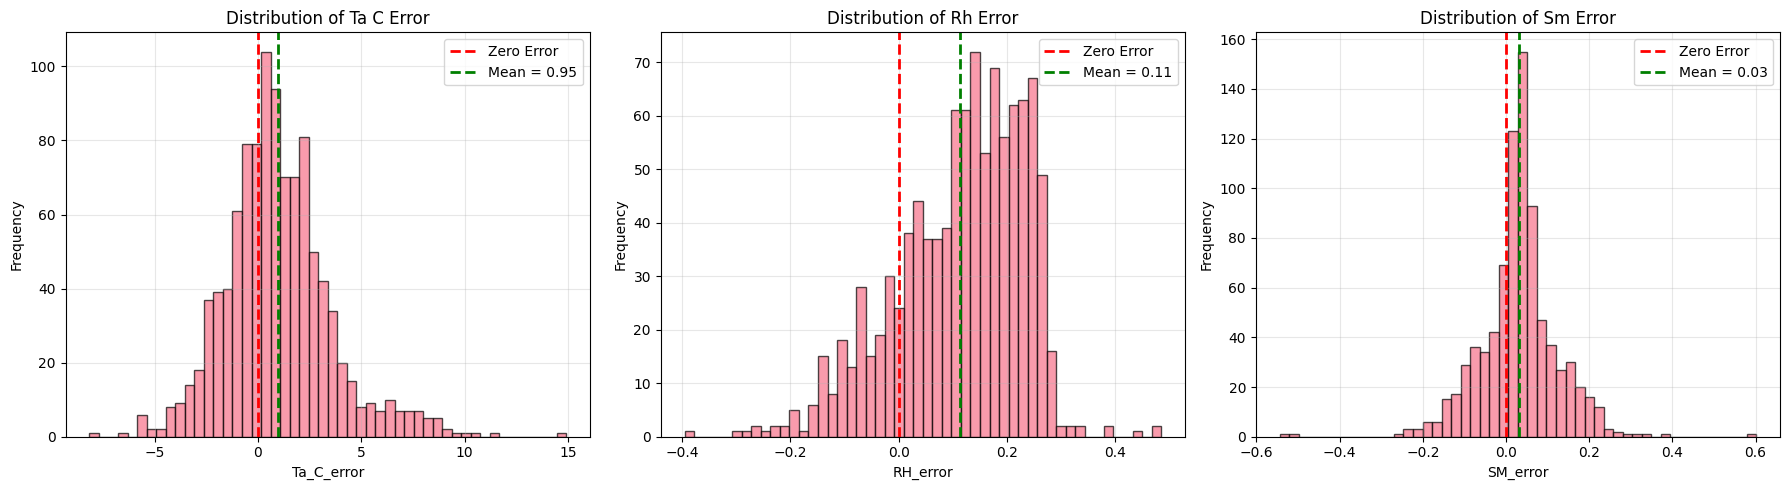

In [21]:
# Distribution plots for all three error metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (ax, metric) in enumerate(zip(axes, error_metrics)):
    data = df[metric].dropna()
    ax.hist(data, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax.axvline(data.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean = {data.mean():.2f}')
    ax.set_xlabel(f'{metric}')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {metric.replace("_", " ").title()}')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

## 5. Correlation Analysis

### 5.1 Function to Calculate Correlations

In [22]:
def calculate_correlations(df, target_col, input_vars):
    """
    Calculate correlation statistics between input variables and target.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    target_col : str
        Name of target column
    input_vars : list
        List of independent variable names
        
    Returns:
    --------
    DataFrame with correlation statistics
    """
    vars_in_df = [v for v in input_vars if v in df.columns]
    numeric_vars = df[vars_in_df].select_dtypes(include=[np.number]).columns.tolist()
    
    rows = []
    for var in numeric_vars:
        pair = df[[var, target_col]].dropna()
        if len(pair) < 3:
            continue
        
        r, p = pearsonr(pair[var], pair[target_col])
        if not (np.isfinite(r) and np.isfinite(p)):
            continue
        
        rows.append({
            "variable": var,
            "correlation": r,
            "r_square": r**2,
            "p_value": p,
            "n": len(pair),
        })
    
    corr_stats = (
        pd.DataFrame(rows)
        .sort_values(by="correlation", key=lambda s: s.abs(), ascending=False)
        .set_index("variable")
    )
    
    return corr_stats

### 5.2 Calculate Correlations for All Three Targets

In [23]:
# Calculate correlations for all three targets
target_cols = ['Ta_C_error_abs', 'RH_error_abs', 'SM_error_abs']
corr_results = {}

for target in target_cols:
    corr_results[target] = calculate_correlations(df, target, INPUT_VARIABLES)
    
    print("=" * 80)
    print(f"CORRELATIONS WITH {target}")
    print("=" * 80)
    print(corr_results[target].to_string(float_format=lambda x: f'{x:.4f}'))
    print("\n")

CORRELATIONS WITH Ta_C_error_abs
                      correlation  r_square  p_value     n
variable                                                  
elevation_m                0.4559    0.2078   0.0000  1048
canopy_height_meters      -0.1526    0.0233   0.0000  1048
SZA_deg                   -0.1349    0.0182   0.0000  1048
NDVI                      -0.1331    0.0177   0.0000  1048
ST_C                       0.1208    0.0146   0.0001  1048
ST_C_error                -0.0838    0.0070   0.0066  1048
albedo                    -0.0584    0.0034   0.0587  1048
emissivity                -0.0199    0.0004   0.5208  1048
wind_speed_mps            -0.0147    0.0002   0.6342  1046


CORRELATIONS WITH RH_error_abs
                      correlation  r_square  p_value     n
variable                                                  
NDVI                      -0.3629    0.1317   0.0000  1027
ST_C                       0.3573    0.1276   0.0000  1027
ST_C_error                -0.2707    0.0733   0.0

### 5.3 Visualize Correlations Across All Targets

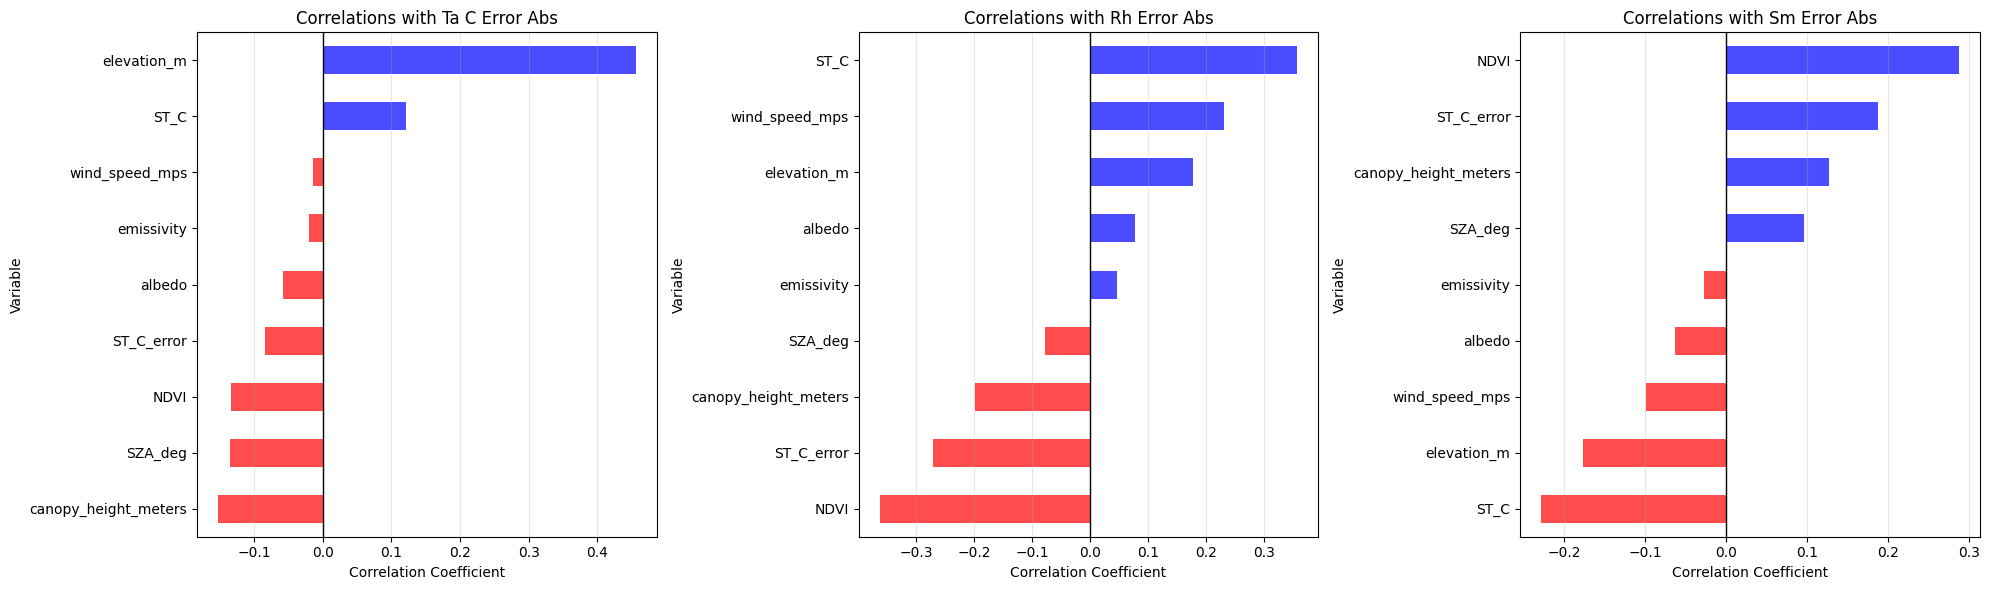

In [24]:
# Create comparison plot of correlations across all three targets
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (ax, target) in enumerate(zip(axes, target_cols)):
    correlations = corr_results[target]['correlation'].sort_values()
    colors = ['red' if c < 0 else 'blue' for c in correlations]
    
    correlations.plot(kind='barh', ax=ax, color=colors, alpha=0.7)
    ax.set_xlabel('Correlation Coefficient')
    ax.set_ylabel('Variable')
    ax.set_title(f'Correlations with {target.replace("_", " ").title()}')
    ax.grid(True, axis='x', alpha=0.3)
    ax.axvline(0, color='black', linewidth=1)

plt.tight_layout()
plt.show()

## 6. OLS Regression Analysis

### 6.1 Function to Perform OLS Regression with Statistical Inference

In [25]:
def perform_ols_regression(df, target_col, input_vars, top_n=None):
    """
    Perform OLS regression with statistical inference.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    target_col : str
        Name of target column
    input_vars : list or DataFrame index
        Independent variables to use
    top_n : int, optional
        Number of top correlated variables to use
        
    Returns:
    --------
    dict with regression results
    """
    # If input_vars is a correlation result, extract variable names
    if isinstance(input_vars, pd.core.indexes.base.Index):
        if top_n:
            predictor_vars = input_vars[:top_n].tolist()
        else:
            predictor_vars = input_vars.tolist()
    else:
        predictor_vars = input_vars
    
    # Prepare data
    X = df[predictor_vars].dropna()
    y = df.loc[X.index, target_col].dropna()
    
    # Align X and y
    common_idx = X.index.intersection(y.index)
    X = X.loc[common_idx]
    y = y.loc[common_idx]
    
    # Fit OLS regression (scikit-learn)
    ols_model = LinearRegression()
    ols_model.fit(X, y)
    
    # Fit OLS regression (statsmodels for inference)
    X_sm = sm.add_constant(X, has_constant="add")
    ols_inference = sm.OLS(y, X_sm).fit()
    
    # Get coefficients with p-values
    coef_df = pd.DataFrame({
        'Variable': predictor_vars,
        'Coefficient': ols_model.coef_,
        'p_value': ols_inference.pvalues.reindex(predictor_vars).values
    }).sort_values('Coefficient', key=lambda x: x.abs(), ascending=False)
    
    # Calculate predictions and metrics
    y_pred = ols_model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    
    # Calculate VIF
    vif_vals = []
    for i, col in enumerate(X.columns):
        vif_vals.append((col, variance_inflation_factor(X.values, i)))
    vif_df = pd.DataFrame(vif_vals, columns=['Variable', 'VIF']).sort_values('VIF', ascending=False)
    
    return {
        'model': ols_model,
        'inference': ols_inference,
        'coefficients': coef_df,
        'vif': vif_df,
        'X': X,
        'y': y,
        'y_pred': y_pred,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'predictor_vars': predictor_vars
    }

### 6.2 Air Temperature Regression Model

In [26]:
# Use top correlated variables for air temperature
ta_results = perform_ols_regression(
    df, 
    'Ta_C_error', 
    corr_results['Ta_C_error_abs'].index,
    top_n=len(INPUT_VARIABLES)
)

print("=" * 80)
print("AIR TEMPERATURE REGRESSION RESULTS")
print("=" * 80)
print(f"\nModel Performance:")
print(f"  R² = {ta_results['r2']:.4f}")
print(f"  RMSE = {ta_results['rmse']:.4f}")
print(f"  MAE = {ta_results['mae']:.4f}")
print(f"  Observations = {len(ta_results['y'])}")

print(f"\nRegression Coefficients:")
print(ta_results['coefficients'].to_string(index=False, float_format=lambda v: f"{v:.6f}"))

print(f"\nVariance Inflation Factors (VIF):")
print(ta_results['vif'].to_string(index=False, float_format=lambda v: f"{v:.2f}"))

AIR TEMPERATURE REGRESSION RESULTS

Model Performance:
  R² = 0.2979
  RMSE = 2.1655
  MAE = 1.6198
  Observations = 1046

Regression Coefficients:
            Variable  Coefficient  p_value
          emissivity    -4.594842 0.391962
                NDVI     1.723500 0.000307
              albedo     1.382063 0.276812
          ST_C_error     0.189330 0.367220
      wind_speed_mps    -0.073005 0.148243
             SZA_deg    -0.043914 0.000000
canopy_height_meters    -0.033175 0.001375
         elevation_m     0.002230 0.000000
                ST_C    -0.002103 0.799444

Variance Inflation Factors (VIF):
            Variable   VIF
          emissivity 88.72
             SZA_deg 18.43
                ST_C 14.94
          ST_C_error 13.21
                NDVI 13.14
         elevation_m  6.20
              albedo  5.21
      wind_speed_mps  4.72
canopy_height_meters  2.86


### 6.3 Humidity Regression Model

In [27]:
# Use top correlated variables for humidity
rh_results = perform_ols_regression(
    df, 
    'RH_error', 
    corr_results['RH_error_abs'].index,
    top_n=len(INPUT_VARIABLES)
)

print("=" * 80)
print("HUMIDITY REGRESSION RESULTS")
print("=" * 80)
print(f"\nModel Performance:")
print(f"  R² = {rh_results['r2']:.4f}")
print(f"  RMSE = {rh_results['rmse']:.4f}")
print(f"  MAE = {rh_results['mae']:.4f}")
print(f"  Observations = {len(rh_results['y'])}")

print(f"\nRegression Coefficients:")
print(rh_results['coefficients'].to_string(index=False, float_format=lambda v: f"{v:.6f}"))

print(f"\nVariance Inflation Factors (VIF):")
print(rh_results['vif'].to_string(index=False, float_format=lambda v: f"{v:.2f}"))

HUMIDITY REGRESSION RESULTS

Model Performance:
  R² = 0.3527
  RMSE = 0.0954
  MAE = 0.0694
  Observations = 1025

Regression Coefficients:
            Variable  Coefficient  p_value
          emissivity     0.219728 0.375403
                NDVI    -0.097065 0.000005
          ST_C_error    -0.090083 0.000000
      wind_speed_mps     0.008802 0.000107
              albedo    -0.007005 0.900774
                ST_C     0.005066 0.000000
canopy_height_meters     0.002630 0.000000
             SZA_deg     0.001233 0.000009
         elevation_m    -0.000009 0.173112

Variance Inflation Factors (VIF):
            Variable   VIF
          emissivity 90.44
             SZA_deg 18.70
                ST_C 14.96
          ST_C_error 13.21
                NDVI 12.89
         elevation_m  6.28
              albedo  5.17
      wind_speed_mps  4.83
canopy_height_meters  2.92


### 6.4 Soil Moisture Regression Model

In [28]:
# Use top correlated variables for soil moisture
sm_results = perform_ols_regression(
    df, 
    'SM_error', 
    corr_results['SM_error_abs'].index,
    top_n=len(INPUT_VARIABLES)
)

print("=" * 80)
print("SOIL MOISTURE REGRESSION RESULTS")
print("=" * 80)
print(f"\nModel Performance:")
print(f"  R² = {sm_results['r2']:.4f}")
print(f"  RMSE = {sm_results['rmse']:.4f}")
print(f"  MAE = {sm_results['mae']:.4f}")
print(f"  Observations = {len(sm_results['y'])}")

print(f"\nRegression Coefficients:")
print(sm_results['coefficients'].to_string(index=False, float_format=lambda v: f"{v:.6f}"))

print(f"\nVariance Inflation Factors (VIF):")
print(sm_results['vif'].to_string(index=False, float_format=lambda v: f"{v:.2f}"))

SOIL MOISTURE REGRESSION RESULTS

Model Performance:
  R² = 0.0583
  RMSE = 0.0909
  MAE = 0.0621
  Observations = 831

Regression Coefficients:
            Variable  Coefficient  p_value
          emissivity     0.276156 0.261855
                NDVI     0.071286 0.001902
              albedo     0.036588 0.521811
          ST_C_error    -0.007086 0.457295
      wind_speed_mps    -0.005022 0.034829
canopy_height_meters    -0.002007 0.000022
             SZA_deg     0.000504 0.077423
                ST_C     0.000251 0.524528
         elevation_m     0.000030 0.000015

Variance Inflation Factors (VIF):
            Variable   VIF
          emissivity 86.07
             SZA_deg 17.64
                ST_C 14.63
                NDVI 14.62
          ST_C_error 13.18
         elevation_m  6.13
              albedo  5.10
      wind_speed_mps  4.54
canopy_height_meters  3.15


## 7. Variable Selection Based on Statistical Criteria

### 7.1 Function to Select Significant Variables

In [29]:
def select_significant_variables(corr_stats, regression_results, 
                                p_threshold=0.05, vif_threshold=10.0, corr_threshold=0.1):
    """
    Select variables based on statistical significance criteria.
    
    Parameters:
    -----------
    corr_stats : DataFrame
        Correlation statistics
    regression_results : dict
        Results from OLS regression
    p_threshold : float
        P-value threshold for significance
    vif_threshold : float
        VIF threshold for multicollinearity
    corr_threshold : float
        Minimum absolute correlation threshold
        
    Returns:
    --------
    DataFrame with selection analysis
    """
    # Merge correlation and regression results
    vif_dict = dict(zip(regression_results['vif']['Variable'], 
                       regression_results['vif']['VIF']))
    coef_dict = dict(zip(regression_results['coefficients']['Variable'],
                        regression_results['coefficients']['Coefficient']))
    pval_dict = dict(zip(regression_results['coefficients']['Variable'],
                        regression_results['coefficients']['p_value']))
    
    # Create selection dataframe
    selection_df = pd.DataFrame({
        'correlation': corr_stats['correlation'],
        'abs_correlation': corr_stats['correlation'].abs(),
        'p_value': corr_stats.index.map(pval_dict),
        'vif': corr_stats.index.map(vif_dict),
        'coefficient': corr_stats.index.map(coef_dict)
    })
    
    # Apply selection criteria
    selection_df['significant_p'] = selection_df['p_value'] < p_threshold
    selection_df['low_vif'] = selection_df['vif'] < vif_threshold
    selection_df['strong_correlation'] = selection_df['abs_correlation'] > corr_threshold
    
    # Select variables meeting ALL criteria
    selection_df['selected'] = (
        selection_df['significant_p'] & 
        selection_df['low_vif'] & 
        selection_df['strong_correlation']
    )
    
    # Sort by absolute correlation
    selection_df = selection_df.sort_values('abs_correlation', ascending=False)
    
    return selection_df

### 7.2 Apply Variable Selection to All Targets

In [30]:
# Apply variable selection for all three targets
ta_selection = select_significant_variables(
    corr_results['Ta_C_error_abs'], 
    ta_results
)

rh_selection = select_significant_variables(
    corr_results['RH_error_abs'], 
    rh_results
)

sm_selection = select_significant_variables(
    corr_results['SM_error_abs'], 
    sm_results
)

# Print selection results
for target_name, selection_df in [
    ('Air Temperature', ta_selection),
    ('Humidity', rh_selection),
    ('Soil Moisture', sm_selection)
]:
    selected_vars = selection_df[selection_df['selected']].index.tolist()
    
    print("=" * 80)
    print(f"VARIABLE SELECTION: {target_name.upper()}")
    print("=" * 80)
    print(f"\nSelection Criteria:")
    print(f"  • P-value < 0.05")
    print(f"  • VIF < 10")
    print(f"  • |Correlation| > 0.1")
    print(f"\nSelected Variables ({len(selected_vars)}):")
    
    for var in selected_vars:
        row = selection_df.loc[var]
        print(f"  ✓ {var:25s} | r={row['correlation']:7.3f} | p={row['p_value']:.4f} | VIF={row['vif']:6.2f}")
    
    rejected_vars = selection_df[~selection_df['selected']].index.tolist()
    if rejected_vars:
        print(f"\nRejected Variables ({len(rejected_vars)}):")
        for var in rejected_vars:
            row = selection_df.loc[var]
            reasons = []
            if row['p_value'] >= 0.05:
                reasons.append(f"p={row['p_value']:.4f}")
            if row['vif'] >= 10:
                reasons.append(f"VIF={row['vif']:.1f}")
            if row['abs_correlation'] <= 0.1:
                reasons.append(f"|r|={row['abs_correlation']:.3f}")
            print(f"  ✗ {var:25s} | {', '.join(reasons)}")
    
    print("\n")

VARIABLE SELECTION: AIR TEMPERATURE

Selection Criteria:
  • P-value < 0.05
  • VIF < 10
  • |Correlation| > 0.1

Selected Variables (2):
  ✓ elevation_m               | r=  0.456 | p=0.0000 | VIF=  6.20
  ✓ canopy_height_meters      | r= -0.153 | p=0.0014 | VIF=  2.86

Rejected Variables (7):
  ✗ SZA_deg                   | VIF=18.4
  ✗ NDVI                      | VIF=13.1
  ✗ ST_C                      | p=0.7994, VIF=14.9
  ✗ ST_C_error                | p=0.3672, VIF=13.2, |r|=0.084
  ✗ albedo                    | p=0.2768, |r|=0.058
  ✗ emissivity                | p=0.3920, VIF=88.7, |r|=0.020
  ✗ wind_speed_mps            | p=0.1482, |r|=0.015


VARIABLE SELECTION: HUMIDITY

Selection Criteria:
  • P-value < 0.05
  • VIF < 10
  • |Correlation| > 0.1

Selected Variables (2):
  ✓ wind_speed_mps            | r=  0.231 | p=0.0001 | VIF=  4.83
  ✓ canopy_height_meters      | r= -0.199 | p=0.0000 | VIF=  2.92

Rejected Variables (7):
  ✗ NDVI                      | VIF=12.9
  ✗ ST_C     

## 8. Refined Models with Selected Variables

### 8.1 Build Refined Models Using Selected Variables

In [31]:
# Build refined models with selected variables
ta_selected_vars = ta_selection[ta_selection['selected']].index.tolist()
rh_selected_vars = rh_selection[rh_selection['selected']].index.tolist()
sm_selected_vars = sm_selection[sm_selection['selected']].index.tolist()

# Refit models with selected variables
ta_refined = perform_ols_regression(df, 'Ta_C_error', ta_selected_vars) if ta_selected_vars else None
rh_refined = perform_ols_regression(df, 'RH_error', rh_selected_vars) if rh_selected_vars else None
sm_refined = perform_ols_regression(df, 'SM_error', sm_selected_vars) if sm_selected_vars else None

# Print refined model results
for target_name, refined_results, original_results in [
    ('Air Temperature', ta_refined, ta_results),
    ('Humidity', rh_refined, rh_results),
    ('Soil Moisture', sm_refined, sm_results)
]:
    print("=" * 80)
    print(f"REFINED MODEL: {target_name.upper()}")
    print("=" * 80)
    
    if refined_results:
        print(f"\nOriginal Model (all variables):")
        print(f"  R² = {original_results['r2']:.4f}  |  RMSE = {original_results['rmse']:.4f}")
        
        print(f"\nRefined Model (selected variables only):")
        print(f"  R² = {refined_results['r2']:.4f}  |  RMSE = {refined_results['rmse']:.4f}")
        print(f"  Variables used: {len(refined_results['predictor_vars'])}")
        print(f"  {', '.join(refined_results['predictor_vars'])}")
        
        # Check if refined model is better or comparable
        r2_diff = refined_results['r2'] - original_results['r2']
        rmse_diff = refined_results['rmse'] - original_results['rmse']
        
        print(f"\nModel Comparison:")
        print(f"  ΔR² = {r2_diff:+.4f}")
        print(f"  ΔRMSE = {rmse_diff:+.4f}")
    else:
        print("\n⚠️  No variables passed selection criteria. Using original model.")
    
    print("\n")

REFINED MODEL: AIR TEMPERATURE

Original Model (all variables):
  R² = 0.2979  |  RMSE = 2.1655

Refined Model (selected variables only):
  R² = 0.2134  |  RMSE = 2.2913
  Variables used: 2
  elevation_m, canopy_height_meters

Model Comparison:
  ΔR² = -0.0845
  ΔRMSE = +0.1258


REFINED MODEL: HUMIDITY

Original Model (all variables):
  R² = 0.3527  |  RMSE = 0.0954

Refined Model (selected variables only):
  R² = 0.0983  |  RMSE = 0.1126
  Variables used: 2
  wind_speed_mps, canopy_height_meters

Model Comparison:
  ΔR² = -0.2545
  ΔRMSE = +0.0172


REFINED MODEL: SOIL MOISTURE

Original Model (all variables):
  R² = 0.0583  |  RMSE = 0.0909

Refined Model (selected variables only):
  R² = 0.0317  |  RMSE = 0.0921
  Variables used: 2
  elevation_m, canopy_height_meters

Model Comparison:
  ΔR² = -0.0266
  ΔRMSE = +0.0012




## 9. Model Comparison and Evaluation

### 9.1 Compare Performance Across All Three Targets

MODEL PERFORMANCE COMPARISON
         Target  N Variables     R²   RMSE    MAE  N Observations
Air Temperature            2 0.2134 2.2913 1.7187            1048
       Humidity            2 0.0983 0.1126 0.0893            1025
  Soil Moisture            2 0.0317 0.0921 0.0635             833


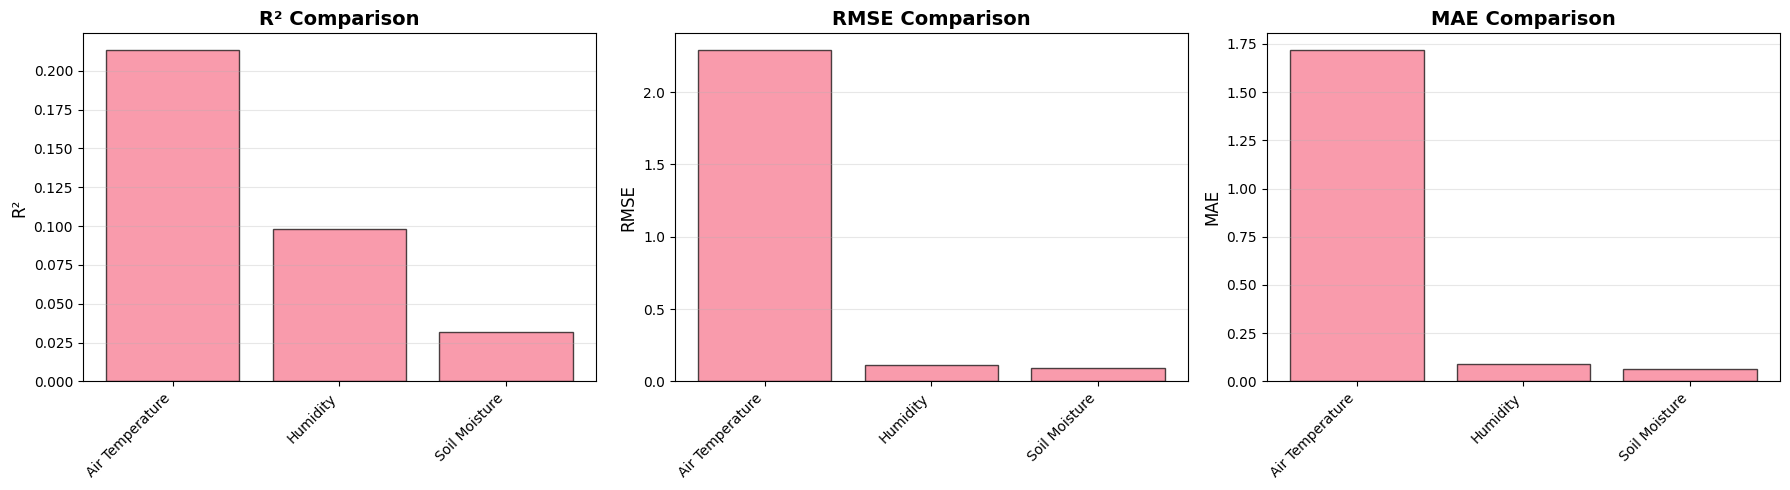

In [32]:
# Create comparison table
comparison_data = []

for target_name, refined, original in [
    ('Air Temperature', ta_refined, ta_results),
    ('Humidity', rh_refined, rh_results),
    ('Soil Moisture', sm_refined, sm_results)
]:
    results = refined if refined else original
    comparison_data.append({
        'Target': target_name,
        'N Variables': len(results['predictor_vars']),
        'R²': results['r2'],
        'RMSE': results['rmse'],
        'MAE': results['mae'],
        'N Observations': len(results['y'])
    })

comparison_df = pd.DataFrame(comparison_data)

print("=" * 80)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['R²', 'RMSE', 'MAE']
for ax, metric in zip(axes, metrics):
    ax.bar(comparison_df['Target'], comparison_df[metric], alpha=0.7, edgecolor='black')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_xticklabels(comparison_df['Target'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 10. Residual Analysis

### 10.1 Predicted vs Observed Plots

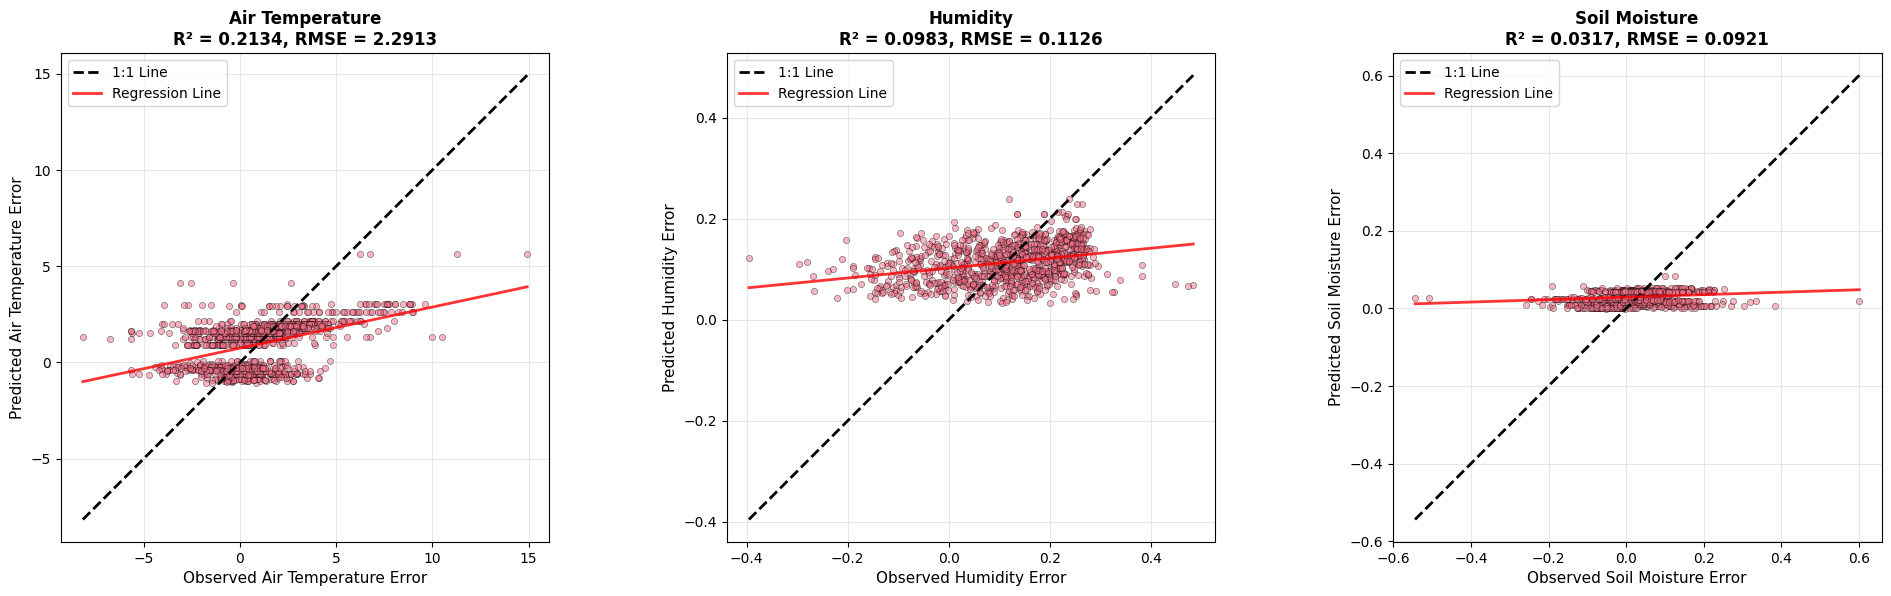

In [33]:
# Create predicted vs observed plots for all three targets
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, (target_name, results) in zip(axes, [
    ('Air Temperature', ta_refined if ta_refined else ta_results),
    ('Humidity', rh_refined if rh_refined else rh_results),
    ('Soil Moisture', sm_refined if sm_refined else sm_results)
]):
    y_true = results['y']
    y_pred = results['y_pred']
    
    ax.scatter(y_true, y_pred, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
    
    # Add 1:1 line
    min_lim = min(y_true.min(), y_pred.min())
    max_lim = max(y_true.max(), y_pred.max())
    ax.plot([min_lim, max_lim], [min_lim, max_lim], 'k--', linewidth=2, label='1:1 Line')
    
    # Add regression line
    z = np.polyfit(y_true, y_pred, 1)
    p = np.poly1d(z)
    ax.plot([min_lim, max_lim], p([min_lim, max_lim]), 'r-', linewidth=2, alpha=0.8, label='Regression Line')
    
    ax.set_xlabel(f'Observed {target_name} Error', fontsize=11)
    ax.set_ylabel(f'Predicted {target_name} Error', fontsize=11)
    ax.set_title(f'{target_name}\nR² = {results["r2"]:.4f}, RMSE = {results["rmse"]:.4f}', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

### 10.2 Residual Distribution Plots

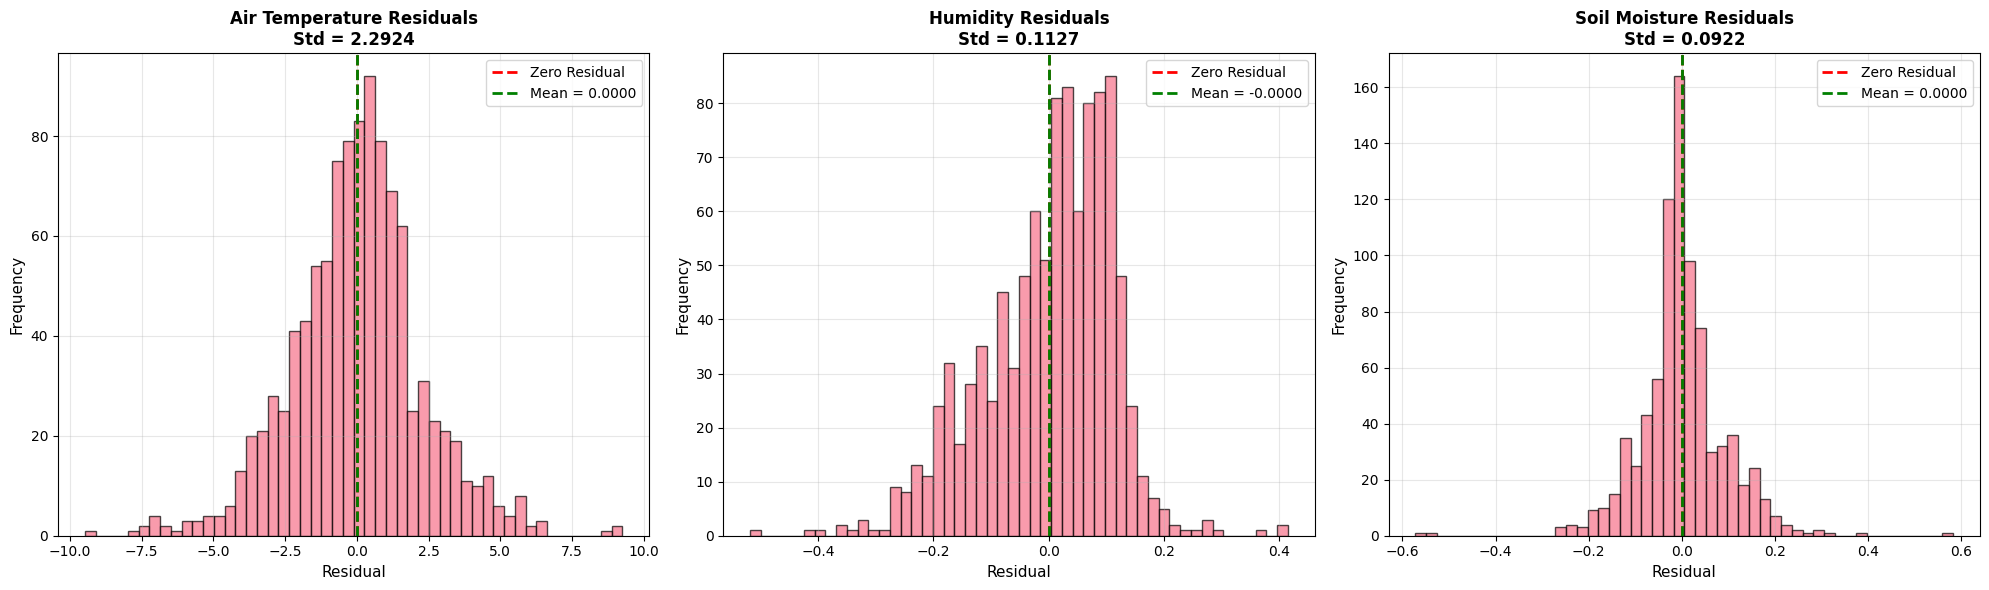

In [34]:
# Residual distribution plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, (target_name, results) in zip(axes, [
    ('Air Temperature', ta_refined if ta_refined else ta_results),
    ('Humidity', rh_refined if rh_refined else rh_results),
    ('Soil Moisture', sm_refined if sm_refined else sm_results)
]):
    residuals = results['y'] - results['y_pred']
    
    ax.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
    ax.axvline(residuals.mean(), color='green', linestyle='--', linewidth=2, 
              label=f'Mean = {residuals.mean():.4f}')
    
    ax.set_xlabel('Residual', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{target_name} Residuals\nStd = {residuals.std():.4f}', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

### 10.3 Residuals vs Fitted Values

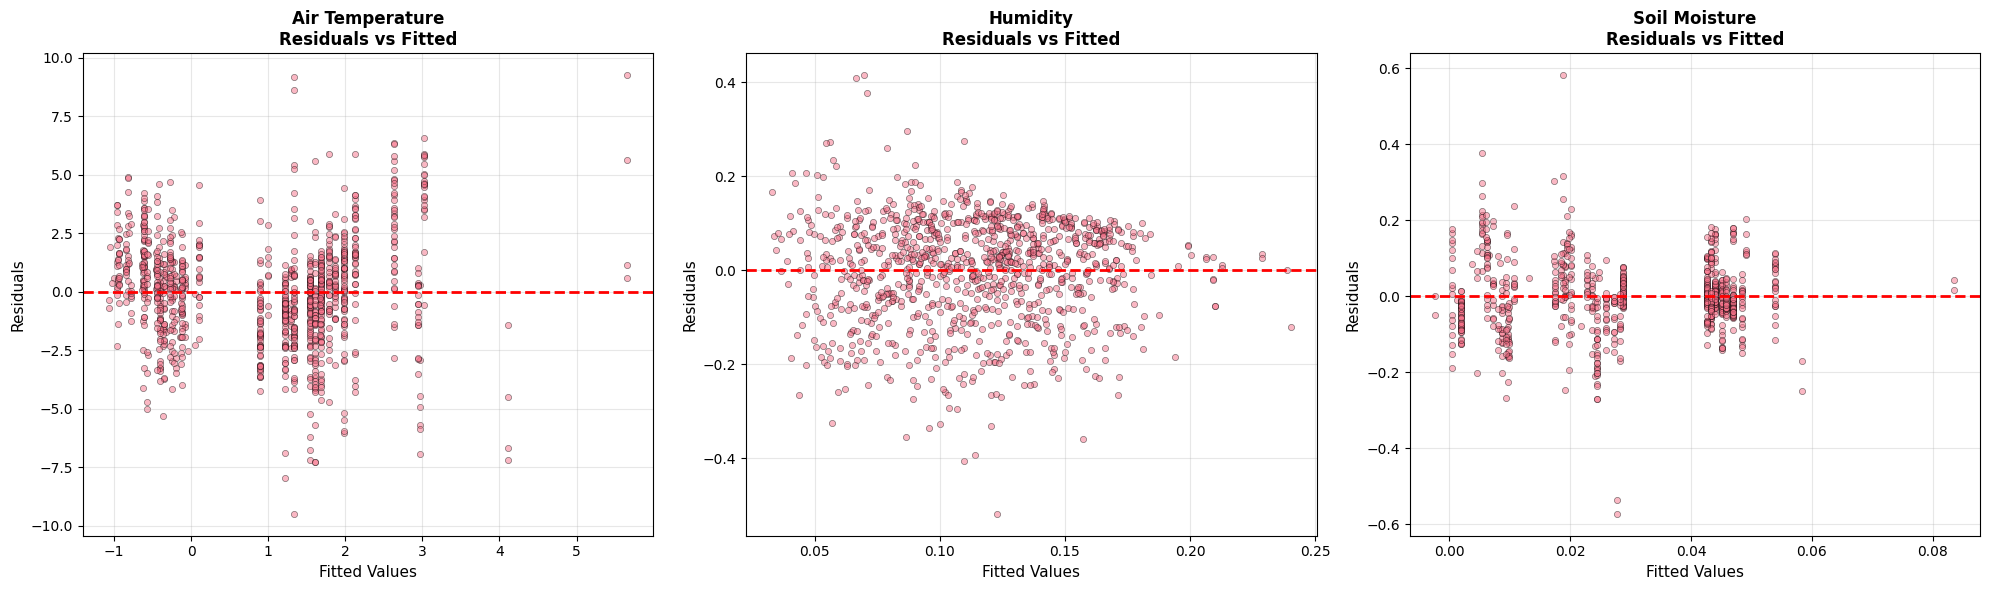

In [35]:
# Residuals vs fitted values plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, (target_name, results) in zip(axes, [
    ('Air Temperature', ta_refined if ta_refined else ta_results),
    ('Humidity', rh_refined if rh_refined else rh_results),
    ('Soil Moisture', sm_refined if sm_refined else sm_results)
]):
    residuals = results['y'] - results['y_pred']
    fitted = results['y_pred']
    
    ax.scatter(fitted, residuals, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
    ax.axhline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Fitted Values', fontsize=11)
    ax.set_ylabel('Residuals', fontsize=11)
    ax.set_title(f'{target_name}\nResiduals vs Fitted', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Feature Importance Analysis

### 11.1 Compare Variable Importance Across Targets

COEFFICIENT COMPARISON ACROSS TARGETS
            Variable  Ta_C_coef  Ta_C_pval  RH_coef  RH_pval  SM_coef  SM_pval
canopy_height_meters    -0.0101     0.2387  -0.0018   0.0000  -0.0009   0.0193
         elevation_m     0.0019     0.0000      NaN      NaN   0.0000   0.0009
      wind_speed_mps        NaN        NaN   0.0183   0.0000      NaN      NaN


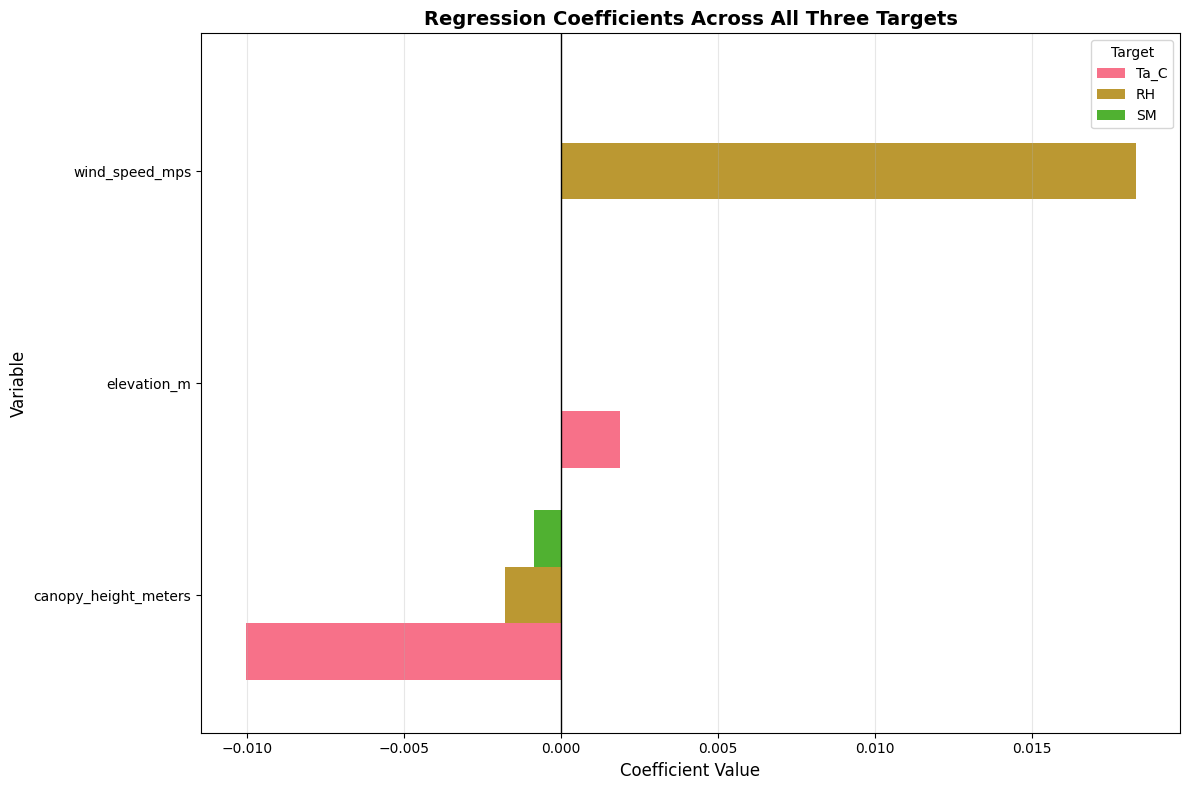

In [36]:
# Create feature importance comparison
all_vars = set()
for results in [ta_refined or ta_results, rh_refined or rh_results, sm_refined or sm_results]:
    all_vars.update(results['predictor_vars'])

# Build comparison dataframe
importance_data = []
for var in sorted(all_vars):
    row = {'Variable': var}
    
    for target_name, results in [
        ('Ta_C', ta_refined or ta_results),
        ('RH', rh_refined or rh_results),
        ('SM', sm_refined or sm_results)
    ]:
        if var in results['predictor_vars']:
            coef = results['coefficients'][results['coefficients']['Variable'] == var]['Coefficient'].values[0]
            pval = results['coefficients'][results['coefficients']['Variable'] == var]['p_value'].values[0]
            row[f'{target_name}_coef'] = coef
            row[f'{target_name}_pval'] = pval
        else:
            row[f'{target_name}_coef'] = np.nan
            row[f'{target_name}_pval'] = np.nan
    
    importance_data.append(row)

importance_df = pd.DataFrame(importance_data)

print("=" * 80)
print("COEFFICIENT COMPARISON ACROSS TARGETS")
print("=" * 80)
print(importance_df.to_string(index=False, float_format=lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A'))

# Visualize coefficient comparison
coef_cols = [col for col in importance_df.columns if col.endswith('_coef')]
plot_df = importance_df.set_index('Variable')[coef_cols]
plot_df.columns = [col.replace('_coef', '') for col in plot_df.columns]

fig, ax = plt.subplots(figsize=(12, 8))
plot_df.plot(kind='barh', ax=ax, width=0.8)
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_ylabel('Variable', fontsize=12)
ax.set_title('Regression Coefficients Across All Three Targets', fontsize=14, fontweight='bold')
ax.grid(True, axis='x', alpha=0.3)
ax.legend(title='Target', loc='best')
ax.axvline(0, color='black', linewidth=1)

plt.tight_layout()
plt.show()

## 12. Summary and Conclusions

In [37]:
print("=" * 80)
print("METEOROLOGY UNCERTAINTY QUANTIFICATION - SUMMARY")
print("=" * 80)

print("\n📊 MODEL PERFORMANCE SUMMARY:\n")
for target_name, results in [
    ('Air Temperature Error', ta_refined or ta_results),
    ('Humidity Error', rh_refined or rh_results),
    ('Soil Moisture Error', sm_refined or sm_results)
]:
    print(f"{target_name}:")
    print(f"  • R² = {results['r2']:.4f}")
    print(f"  • RMSE = {results['rmse']:.4f}")
    print(f"  • MAE = {results['mae']:.4f}")
    print(f"  • Variables used: {len(results['predictor_vars'])}")
    print(f"    {', '.join(results['predictor_vars'])}")
    print()

print("=" * 80)
print("\n🔑 KEY FINDINGS:\n")

# Identify common important variables
ta_vars = set((ta_refined or ta_results)['predictor_vars'])
rh_vars = set((rh_refined or rh_results)['predictor_vars'])
sm_vars = set((sm_refined or sm_results)['predictor_vars'])

common_vars = ta_vars & rh_vars & sm_vars
print(f"Variables important for ALL three targets ({len(common_vars)}):")
for var in sorted(common_vars):
    print(f"  • {var}")

print(f"\nVariables unique to Air Temperature ({len(ta_vars - rh_vars - sm_vars)}):")
for var in sorted(ta_vars - rh_vars - sm_vars):
    print(f"  • {var}")

print(f"\nVariables unique to Humidity ({len(rh_vars - ta_vars - sm_vars)}):")
for var in sorted(rh_vars - ta_vars - sm_vars):
    print(f"  • {var}")

print(f"\nVariables unique to Soil Moisture ({len(sm_vars - ta_vars - rh_vars)}):")
for var in sorted(sm_vars - ta_vars - rh_vars):
    print(f"  • {var}")

print("\n" + "=" * 80)

METEOROLOGY UNCERTAINTY QUANTIFICATION - SUMMARY

📊 MODEL PERFORMANCE SUMMARY:

Air Temperature Error:
  • R² = 0.2134
  • RMSE = 2.2913
  • MAE = 1.7187
  • Variables used: 2
    elevation_m, canopy_height_meters

Humidity Error:
  • R² = 0.0983
  • RMSE = 0.1126
  • MAE = 0.0893
  • Variables used: 2
    wind_speed_mps, canopy_height_meters

Soil Moisture Error:
  • R² = 0.0317
  • RMSE = 0.0921
  • MAE = 0.0635
  • Variables used: 2
    elevation_m, canopy_height_meters


🔑 KEY FINDINGS:

Variables important for ALL three targets (1):
  • canopy_height_meters

Variables unique to Air Temperature (0):

Variables unique to Humidity (1):
  • wind_speed_mps

Variables unique to Soil Moisture (0):

